# TSP Problem With Genetic Algorithm & Visualization

# Import

In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
from itertools import combinations
from collections import defaultdict
from matplotlib import rc

rc('font', family= 'LG PC')
plt.style.use('seaborn-colorblind')
%matplotlib inline

# Data

In [2]:
data = pd.read_csv('europe.csv')

In [3]:
data.head()

,country,capital,latitude,longitude
0,Albania,Tirana,41.3317,19.8172
1,Austria,Vienna,48.2092,16.3728
2,Belarus,Minsk,53.9678,27.5766
3,Belgium,Brussels,50.8371,4.3676
4,Bosnia and Herzegovina,Sarajevo,43.8608,18.4214


In [4]:
data.describe()

,latitude,longitude
count,49.000000,49.000000
mean,48.576733,16.418943
std,6.342214,12.334266
min,37.377200,-9.135500
25%,42.674000,10.220000
50%,48.209200,18.421400
75%,53.951000,24.350000
max,60.169900,55.947100


# Harversine

In [5]:
def distance(country_A, country_B):
    # country_A, Country_B are pairs of latitude and longtitude in list form.
    lat1, lon1 = country_A
    lat2, lon2 = country_B
    radius = 6371 # radius of Earth in Km
    
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    
    a = pow(math.sin(dlat/2), 2) + pow(math.sin(dlon/2), 2) * math.cos(math.radians(lat1)) * math.cos(math.radians(lat2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    
    return d

# Distance Matrix

In [6]:
city_dict = defaultdict(list)
for _, row in data.iterrows():
    city_dict[row['capital']].append(row['latitude'])
    city_dict[row['capital']].append(row['longitude'])

In [7]:
dist_matrix = np.zeros((49, 49))
city_to_index = {}
index_to_city = {}
for dep_index, dep_city in enumerate(city_dict.keys()):
    city_to_index[dep_city] = dep_index
    index_to_city[dep_index] = dep_city
    for arr_index, arr_city in enumerate(city_dict.keys()):
        dist_matrix[dep_index][arr_index] = distance(city_dict[dep_city], city_dict[arr_city])

In [8]:
dist_matrix

array([[   0.        ,  811.41969185, 1518.36938035, ..., 2324.09773469,
        2036.53398903, 2015.58535837],
       [ 811.41969185,    0.        , 1009.09733444, ..., 1581.19655704,
        1313.10300091, 1372.86501205],
       [1518.36938035, 1009.09733444,    0.        , ..., 1959.64132919,
        1800.77248701, 2004.7412392 ],
       ...,
       [2324.09773469, 1581.19655704, 1959.64132919, ...,    0.        ,
         295.92968324,  499.67341784],
       [2036.53398903, 1313.10300091, 1800.77248701, ...,  295.92968324,
           0.        ,  304.50960808],
       [2015.58535837, 1372.86501205, 2004.7412392 , ...,  499.67341784,
         304.50960808,    0.        ]])

# Genetic Algorithm

In [9]:
class GeneticAlgorithm:
    
    def __init__(self, top_only=True, **kwargs):
        self.top_only = top_only
        self.dist_matrix = kwargs['dist_matrix']
        self.carry_over_rate = kwargs['carry_over']
        self.cross_over_rate = kwargs['cross_over']
        self.random_rate = 1 - self.carry_over_rate - self.cross_over_rate
        self.num_pop=kwargs['pop']
        self.depart_city=kwargs['depart']
        self.arrive_city=kwargs['arrive']
        self.population=[self.genChromosome() for i in range(self.num_pop)]
        self.best = None
        
        if self.random_rate < 0:
            print ('rate error! please check your carry, cross over rate. sum of rate is cannot over 1.')

    def swap(self, i,temp_a,temp_b):
        if i not in temp_b:
            return i
        else:
            idx=temp_b.index(i)
            if temp_a[idx] in temp_b:
                return self.swap(temp_a[idx],temp_a,temp_b)
            else:
                return temp_a[idx]

    def pmx(self, list_a, list_b, start_index, end_index):     
        result_a=[]
        result_b=[]
        temp_a=list_a[start_index:end_index+1]
        temp_b=list_b[start_index:end_index+1]

        for i in range(len(list_a)):
            if i in range(start_index,end_index+1):
                result_a.append(list_b[i])
                result_b.append(list_a[i])            
            else:
                result_a.append(self.swap(list_a[i],temp_a,temp_b))
                result_b.append(self.swap(list_b[i],temp_b,temp_a))

        return result_a,result_b
    
    
    # 목표도시 빼고, 여정 염색체로 만들기
    def genChromosome(self):
        to_permute=list(range(len(self.dist_matrix)))
        if self.depart_city == self.arrive_city:
            to_permute.remove(self.depart_city)
        else:
            to_permute.remove(self.depart_city)
            to_permute.remove(self.arrive_city)
        return list(np.random.permutation(to_permute))
    
    ## 개별 염색체 평가하기
    def evalChromosome(self,chromosome):
        route = [self.depart_city] + chromosome + [self.arrive_city]
        result = 0
        for i in range(0, len(route)-1):
            result += self.dist_matrix[route[i]][route[i+1]]
        return result
    
    # 전세대 염색체 평가하여 정렬하기
    def evalGeneration(self, generation_array):
        result = []
        for chromosome in generation_array:
            result.append([chromosome, self.evalChromosome(chromosome)])
        return sorted(result, reverse=False, key=lambda x: x[1])


    def genNextGeneration(self, generation_array):
        carry_idx = int(self.num_pop * self.carry_over_rate)
        cross_idx = int(self.num_pop * self.cross_over_rate)
        sorted_present = self.evalGeneration(generation_array)
        next_generation = []
        cross_over = []
        
        
        # 비율에 따른 분리
        # cross_over_rate가 0인 경우 carry_over로 cross_over 실행.
        for i in range(self.num_pop):
            if self.top_only == False:
                if i in range(0, carry_idx):
                    next_generation.append(sorted_present[i][0])
                elif i in range(carry_idx, carry_idx+cross_idx):
                    cross_over.append(sorted_present[i][0])
                else:
                    next_generation.append(self.genChromosome())
            elif self.top_only == True:
                if i in range(0, carry_idx):
                    next_generation.append(sorted_present[i][0])
                    cross_over.append(sorted_present[i][0])
                elif i in range(carry_idx, cross_idx):
                    cross_over.append(sorted_present[i][0])
                elif i in range(carry_idx + cross_idx, self.num_pop):
                    next_generation.append(self.genChromosome())
                    
        
        # cross_over 중에서도 랜덤으로 뽑아서 pmx 실행
        # pmx index 또한 랜덤으로.
        comb_list = list(combinations(range(len(cross_over)), 2))
        random.shuffle(comb_list)
        for list_a_index, list_b_index in comb_list:
            if self.depart_city == self.arrive_city:
                rand_index = random.sample(range(len(self.dist_matrix)-1), 2)
            else:
                rand_index = random.sample(range(len(self.dist_matrix)-2), 2)
            for gene in self.pmx(cross_over[list_a_index], cross_over[list_b_index], min(rand_index), max(rand_index)):
                if len(next_generation) == len(sorted_present):
                    return next_generation
                else:
                    next_generation.append(gene)
        return next_generation
    
    # 유전알고리즘 수행
    def do_algorithm(self):
        count = 0
        while True:
            sorted_present = self.evalGeneration(self.population)
            next_generation = self.genNextGeneration(self.population)
            sorted_next = self.evalGeneration(next_generation)
            if sorted_next[0][1] == sorted_present[0][1]:
                count += 1
            else:
                count = 0
            if count == 10000:
                break
            self.population = next_generation 
            self.best = sorted_present[0]
        return sorted_present  

# Result

In [11]:
city_to_index['Paris']

17

In [12]:
def result_all(gen):
    for city_indices, distance in gen.do_algorithm():
        result = []
        for idx in city_indices:
            result.append(index_to_city[idx])
        print('Route: \n\n', result, '\n')
        print('Sum of distance: \n\n', distance, '\n')

def result_best(gen):
    best = gen.do_algorithm()[0]
    result = []
    for idx in best[0]:
        result.append(index_to_city[idx])
    print('Route: \n\n', result, '\n')
    print('Sum of distance: \n\n', best[1], '\n')

# Visualization

* 다양한 population, carry_over_rate, cross_over_rate, random_rate를 적용하기.
* 하나의 gen 객체에서도 시행할 때마다 다른 결과를 나타낼 수 있기 때문에, 각 객체를 10번씩 반복하여 그 결과를 DataFrame에 저장한다.
* 총 50 가지의 조합을 비교해보도록 한다.

In [13]:
pop = [10, 20, 30, 40, 50]
carry_over = [0.1, 0.2, 0.3, 0.4, 0.5]
random_rate = [0.1, 0.2]
comb = [(x, y, z) for x in pop for y in carry_over for z in random_rate]

In [14]:
def grid_search(comb):
    result = []
    for i, arg in enumerate(comb):
        for i in range(10):
            gen = GeneticAlgorithm(dist_matrix=dist_matrix, pop=arg[0], depart=17, arrive=17, carry_over=arg[1], cross_over=1-arg[1]-arg[2])
            gen.do_algorithm()
            result.append([gen.num_pop, gen.carry_over_rate, gen.cross_over_rate, gen.random_rate, gen.best[0], gen.best[1]])
    print(i, 'th args result saved sucessfully...')
    return result            

In [42]:
import pickle

with open('genetic_result.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,num_pop,carry_over_rate,cross_over_rate,random_rate,route,cost
0,10,0.1,0.8,0.1,"[29, 0, 10, 6, 28, 24, 21, 8, 19, 47, 16, 22, ...",50323.470544
1,10,0.1,0.8,0.1,"[48, 29, 5, 37, 22, 19, 12, 39, 25, 24, 40, 43...",46696.945048
2,10,0.1,0.8,0.1,"[41, 33, 47, 25, 40, 11, 39, 28, 16, 2, 45, 8,...",51429.481404
3,10,0.1,0.8,0.1,"[19, 0, 7, 6, 36, 27, 12, 25, 4, 22, 39, 40, 2...",51452.525508
4,10,0.1,0.8,0.1,"[14, 12, 33, 44, 19, 15, 27, 22, 39, 25, 21, 1...",53414.836965


* 각 args의 조합별로 10번을 시행하였는데, 가장 좋은 것만을 남기고 삭제해 준다.

In [43]:
df2 = df.copy()
df2['min_cost'] = df2.groupby(['num_pop', 'carry_over_rate', 'cross_over_rate', 'random_rate'])['cost'].transform(np.min)
df2 = df2.sort_values('cost', ascending=True)
df2 = df2.drop_duplicates(subset=['num_pop', 'carry_over_rate', 'cross_over_rate', 'random_rate', 'min_cost'], keep='first')

In [44]:
df2 = df2.reset_index()
df2.drop(columns=['index', 'min_cost'], inplace=True)

In [45]:
df2['carry_over_rate'] = df2['carry_over_rate'].round(1)
df2['cross_over_rate'] = df2['cross_over_rate'].round(1)
df2['random_rate'] = df2['random_rate'].round(1)

Visualization


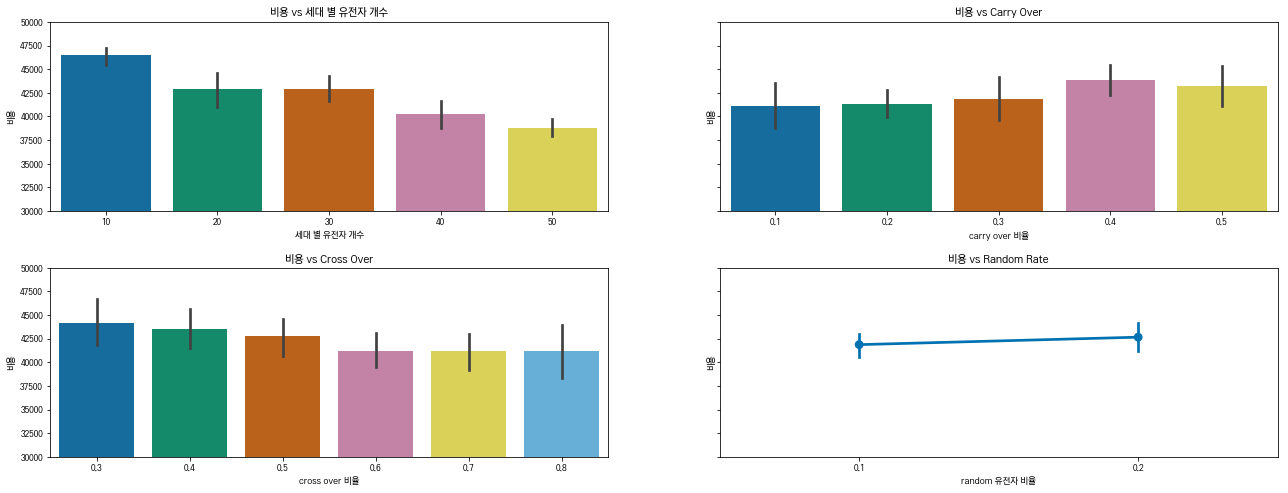

In [49]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True)
figure.set_size_inches(22, 8)
figure.subplots_adjust(hspace=0.3)

ax1.set_ylim(30000, 50000)

sns.barplot(data=df2, x='num_pop', y='cost', ax=ax1)
sns.barplot(data=df2, x='carry_over_rate', y='cost', ax=ax2)
sns.barplot(data=df2, x='cross_over_rate', y='cost', ax=ax3)
sns.pointplot(data=df2, x='random_rate', y='cost', ax=ax4)
ax1.set(xlabel='세대 별 유전자 개수', ylabel='비용', title = '비용 vs 세대 별 유전자 개수')
ax2.set(xlabel='carry over 비율', ylabel='비용', title = '비용 vs Carry Over')
ax3.set(xlabel='cross over 비율', ylabel='비용', title = '비용 vs Cross Over')
ax4.set(xlabel='random 유전자 비율', ylabel='비용', title = '비용 vs Random Rate')

print('Visualization')

* 세대 별 유전자 개수가 많을 수록 평균비용이 꾸준히 감소하는 것을 확인할 수 있었고,  carry over 비율은 너무 크지도 적지도 않은 20%가 적당한 것 같다.
* random 유전자 비율은 더 적게 해볼 필요가 있을 것 같고, 그에 따라 cross over 비율은 크게 하는 것이 좋을 것 같다.

In [ ]:
pop = [60, 70, 80, 90, 100]
carry_over = [0.1, 0.2, 0.3]
random_rate = [0.05]
comb = [(x, y, z) for x in pop for y in carry_over for z in random_rate]

In [ ]:
grid_search(comb)

# Visualization In Map

* 지도 상에 경로를 그려보고 최적에 가까운 경로인지 판단해본다.

In [16]:
import folium
from collections import namedtuple

In [112]:
def get_arrows(locations, color='blue', size=3, n_arrows=3):
    Point = namedtuple('Point', field_names=['lat', 'lon'])    
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    rotation = get_bearing(p1, p2) - 90
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows+2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows+2)[1:n_arrows+1]
    
    arrows = []
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(
            location=points, fill_color=color, number_of_sides=3, radius=size, rotation=rotation))
    return arrows 

In [109]:
def get_bearing(p1, p2):
    long_diff = np.radians(p2.lon - p1.lon)
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(long_diff)))
    
    bearing = np.degrees(np.arctan2(x, y))
    
    if bearing < 0:
        return bearing + 360
    return bearing

In [110]:
def route_in_map(best_route):
    lat_lon_route = []
    for idx in best_route:
        lat_lon_route.append(city_dict[index_to_city[idx]])
        
    route_map = folium.Map(location=[data[data['capital'] == 'Prague']['latitude'], data[data['capital'] == 'Prague']['longitude']],
                    zoom_start=5)
    
    # marker
    for i, idx in enumerate(best_route):
        city_name = index_to_city[idx]
        color = 'beige'
        if i == 0:
            color = 'red'
        elif i == 49:
            break
        folium.Marker(location=city_dict[city_name], popup='route' + str(i) + ': ' + city_name, icon=folium.Icon(color=color)).add_to(route_map)
    
    # line
    for city_idx in range(len(lat_lon_route)-1):
        p1, p2 = lat_lon_route[city_idx], lat_lon_route[city_idx + 1]
        folium.PolyLine(locations=[p1, p2], color='darkgray').add_to(route_map)
        arrows = get_arrows(locations=[p1, p2], n_arrows=3)
        
        for arrow in arrows:
            arrow.add_to(route_map)
    return route_map

In [111]:
best_route = df[df['cost'] == df['cost'].min()]['route'].tolist()[0].copy()
best_route.append(17)
best_route.insert(0, 17)
route_in_map(best_route)

* 지도상의 직선거리로 cost를 정하였다면 최대한 가까운 곳 부터 나선형으로 돌면서 가야 최적일 것 같다.

* 사선으로 가로지르는 경로가 많은 것을 보아 35000에 가까운 cost가 최적인 것 같지는 않다.

* 알고리즘을 여러번 반복해서 다르게 시행해봐야 할 것 같다. 

* local minimum이 많이 존재하는 상황에서 optimum을 빠르게 찾지 못하는 것은 간단한 pmx를 이용한 유전 알고리즘의 한계일지도 모르겠다. 알고리즘의 업그레이드 방안이 필요하다.